# Imports

In [1]:
import os
import time
import json
import pickle
import pathlib
import tabulate
import unicodedata

In [2]:
import nltk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Constants

In [3]:
PROJECT_DIR = pathlib.Path('~/project').expanduser()
DATA_DIR = PROJECT_DIR / 'data'
CORPUS_ROOT = DATA_DIR / 'sample'

# Text Classification

## Identifying Classification Problems

## Classifier Models

# Building a Text Classification Application

## Cross-Validation

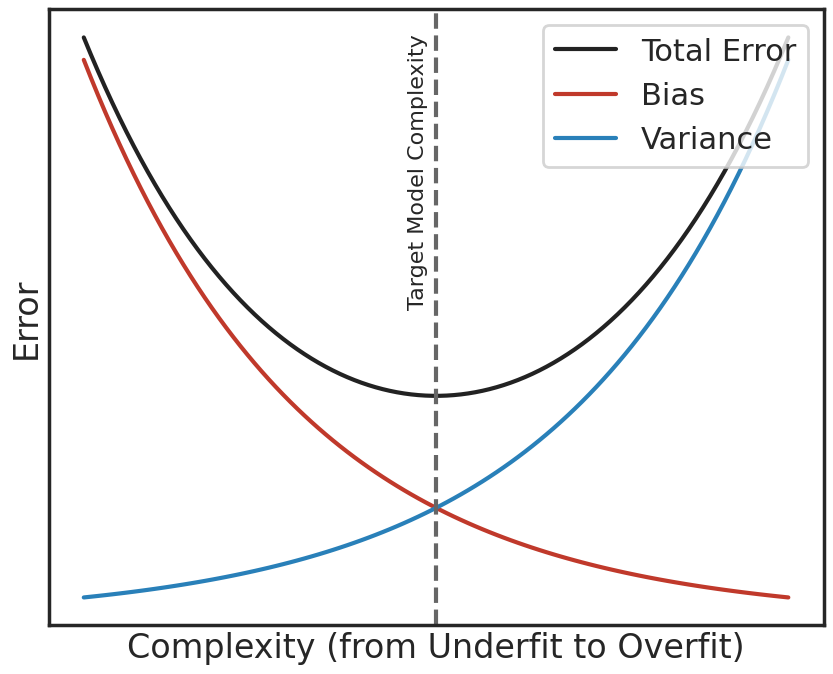

In [4]:
sns.set_style('white')
sns.set_context('poster')
sns.set_palette('dark')

X = np.linspace(-1, 1, 100)
Yvar = 5 ** X
Ybias = (1/5) ** X
Yerr = Ybias + Yvar

fig = plt.figure(figsize=(10, 8))
axe = fig.add_subplot(111)

axe.plot(X, Yerr, '-', color="#222222", label='Total Error')
axe.plot(X, Ybias, '-', color="#c0392b", label="Bias")
axe.plot(X, Yvar, '-', color="#2980b9", label="Variance")

plt.axvline(x=0, color='#666666', linestyle='--')
axe.text(-0.05, 4, "Target Model Complexity", ha="center", va="center", rotation=90, size=16)

plt.legend(loc='upper right')

axe.get_xaxis().set_ticks([])
axe.get_yaxis().set_ticks([])

axe.set_ylabel('Error')
axe.set_xlabel('Complexity (from Underfit to Overfit)')

plt.show()

### Streaming access to k splits

In [5]:
from nltk.corpus.reader.api import CorpusReader
from nltk.corpus.reader.api import CategorizedCorpusReader

In [6]:
DOC_PATTERN = r'(?!\.)[a-z_\s]+/[a-f0-9]+\.json'
PKL_PATTERN = r'(?!\.)[a-z_\s]+/[a-f0-9]+\.pickle'
CAT_PATTERN = r'([a-z_\s]+)/.*'

In [7]:
class PickledCorpusReader(CategorizedCorpusReader, CorpusReader):

    def __init__(self, root, fileids=PKL_PATTERN, **kwargs):
        """
        Initialize the corpus reader.  Categorization arguments
        (``cat_pattern``, ``cat_map``, and ``cat_file``) are passed to
        the ``CategorizedCorpusReader`` constructor.  The remaining arguments
        are passed to the ``CorpusReader`` constructor.
        """
        # Add the default category pattern if not passed into the class.
        if not any(key.startswith('cat_') for key in kwargs.keys()):
            kwargs['cat_pattern'] = CAT_PATTERN

        CategorizedCorpusReader.__init__(self, kwargs)
        CorpusReader.__init__(self, root, fileids)

    def _resolve(self, fileids, categories):
        """
        Returns a list of fileids or categories depending on what is passed
        to each internal corpus reader function. This primarily bubbles up to
        the high level ``docs`` method, but is implemented here similar to
        the nltk ``CategorizedPlaintextCorpusReader``.
        """
        if fileids is not None and categories is not None:
            raise ValueError("Specify fileids or categories, not both")

        if categories is not None:
            return self.fileids(categories)
        return fileids

    def docs(self, fileids=None, categories=None):
        """
        Returns the document loaded from a pickled object for every file in
        the corpus. Similar to the BaleenCorpusReader, this uses a generator
        to acheive memory safe iteration.
        """
        # Resolve the fileids and the categories
        fileids = self._resolve(fileids, categories)

        # Create a generator, loading one document into memory at a time.
        for path, enc, fileid in self.abspaths(fileids, True, True):
            with open(path, 'rb') as f:
                yield pickle.load(f)

    def paras(self, fileids=None, categories=None):
        """
        Returns a generator of paragraphs where each paragraph is a list of
        sentences, which is in turn a list of (token, tag) tuples.
        """
        for doc in self.docs(fileids, categories):
            for paragraph in doc:
                yield paragraph

    def sents(self, fileids=None, categories=None):
        """
        Returns a generator of sentences where each sentence is a list of
        (token, tag) tuples.
        """
        for paragraph in self.paras(fileids, categories):
            for sentence in paragraph:
                yield sentence

    def words(self, fileids=None, categories=None):
        """
        Returns a generator of (token, tag) tuples.
        """
        for sent in self.sents(fileids, categories):
            for token, tag in sent:
                yield token, tag

In [8]:
from collections import Counter

reader = PickledCorpusReader(root=CORPUS_ROOT.as_posix())
words  = Counter(reader.words())

print(f"{len(words.keys()):,} vocabulary {sum(words.values()):,} word count")

77,930 vocabulary 1,624,862 word count


In [9]:
for category in reader.categories():

    n_docs = len(reader.fileids(categories=[category]))
    n_words = sum(1 for word in reader.words(categories=[category]))

    print("- '{}' contains {:,} docs and {:,} words".format(category, n_docs, n_words))

- 'books' contains 71 docs and 41,438 words
- 'business' contains 389 docs and 222,182 words
- 'cinema' contains 100 docs and 69,153 words
- 'cooking' contains 30 docs and 37,854 words
- 'data_science' contains 41 docs and 31,354 words
- 'design' contains 55 docs and 18,260 words
- 'do_it_yourself' contains 122 docs and 28,050 words
- 'gaming' contains 128 docs and 70,778 words
- 'news' contains 1,159 docs and 850,688 words
- 'politics' contains 149 docs and 88,853 words
- 'sports' contains 118 docs and 68,884 words
- 'tech' contains 176 docs and 97,368 words


In [10]:
from sklearn.model_selection import StratifiedKFold

In [11]:
class CorpusLoader(object):

    def __init__(self, reader, 
                 folds=12, shuffle=True,
                 categories=None, random_state=None):
        self.reader = reader
        self.folds  = StratifiedKFold(n_splits=folds, 
                                      shuffle=shuffle, 
                                      random_state=random_state)
        self.files  = np.asarray(self.reader.fileids(categories=categories))

    def fileids(self, idx=None):
        if idx is None:
            return self.files
        return self.files[idx]

    def documents(self, idx=None):
        for fileid in self.fileids(idx):
            yield list(self.reader.docs(fileids=[fileid]))

    def labels(self, idx=None):
        return [
            self.reader.categories(fileids=[fileid])[0]
            for fileid in self.fileids(idx)
        ]

    def __iter__(self):
        for train_index, test_index in self.folds.split(self.fileids(), self.labels()):
            X_train = self.documents(train_index)
            y_train = self.labels(train_index)

            X_test = self.documents(test_index)
            y_test = self.labels(test_index)

            yield X_train, X_test, y_train, y_test

In [12]:
reader = PickledCorpusReader(root=CORPUS_ROOT.as_posix())
loader = CorpusLoader(reader, folds=12, random_state=42)

In [13]:
for fold, (X_train, X_test, y_train, y_test) in enumerate(loader):
    print(f'{fold}:', len(list(X_train)), len(list(X_test)), len(y_train), len(y_test))

0: 2326 212 2326 212
1: 2326 212 2326 212
2: 2326 212 2326 212
3: 2326 212 2326 212
4: 2326 212 2326 212
5: 2326 212 2326 212
6: 2327 211 2327 211
7: 2327 211 2327 211
8: 2327 211 2327 211
9: 2327 211 2327 211
10: 2327 211 2327 211
11: 2327 211 2327 211


## Model Construction

In [14]:
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin

In [15]:
class TextNormalizer(BaseEstimator, TransformerMixin):

    def __init__(self, language='english'):
        self.language = language
        self.stopwords = set(nltk.corpus.stopwords.words(language))
        self.lemmatizer = WordNetLemmatizer()

    def is_punct(self, token):
        return all(
            unicodedata.category(char).startswith('P') for char in token
        )

    def is_stopword(self, token):
        return token.lower() in self.stopwords

    def normalize(self, document):
        return [
            self.lemmatize(token, tag).lower()
            for paragraph in document
            for sentence in paragraph
            for (token, tag) in sentence
            if not self.is_punct(token)
            and not self.is_stopword(token)
        ]

    def lemmatize(self, token, pos_tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(pos_tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

    def fit(self, X, y=None):
        return self

    def transform(self, documents):
        for document in documents:
            yield self.normalize(document[0])

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
def identity(words):
    return words

In [18]:
def create_pipeline(estimator, reduction=False):

    steps = [
        ('normalize', TextNormalizer()),
        ('vectorize', TfidfVectorizer(
            tokenizer=identity, preprocessor=None, lowercase=False
        ))
    ]

    if reduction:
        steps.append((
            'reduction', TruncatedSVD(n_components=10000)
        ))

    # Add the estimator
    steps.append(('classifier', estimator))
    return Pipeline(steps)

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

In [20]:
models = []
for form in (LogisticRegression, SGDClassifier):
    models.append(create_pipeline(form(random_state=42), True))
    models.append(create_pipeline(form(random_state=42), False))
models.append(create_pipeline(MultinomialNB(), False))
models.append(create_pipeline(GaussianNB(), True))

## Model Evaluation

In [21]:
categories = ["books", "cinema", "cooking", "gaming", "sports", "tech"]
reader = PickledCorpusReader(root=CORPUS_ROOT.as_posix())
loader = CorpusLoader(reader, folds=5, random_state=42, categories=categories)

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [23]:
def score_models(models, loader):
    for model in models:

        name = model.named_steps['classifier'].__class__.__name__
        if 'reduction' in model.named_steps:
            name += " (TruncatedSVD)"

        scores = {
            'name': name,
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': [],
            'time': [],
        }

        for X_train, X_test, y_train, y_test in loader:
            start = time.time()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            scores['time'].append(time.time() - start)
            scores['accuracy'].append(accuracy_score(y_test, y_pred))
            scores['precision'].append(precision_score(y_test, y_pred, average='weighted'))
            scores['recall'].append(recall_score(y_test, y_pred, average='weighted'))
            scores['f1'].append(f1_score(y_test, y_pred, average='weighted'))

        yield scores

In [24]:
%%time
%%capture
for scores in score_models(models, loader):
    with open('results.json', 'a') as f:
        f.write(json.dumps(scores) + "\n")

CPU times: user 25min 56s, sys: 1min 9s, total: 27min 6s
Wall time: 5min 52s


In [25]:
fields = ['model', 'time', 'precision', 'recall', 'accuracy', 'f1']
table = []

with open('results.json', 'r') as f:
    for idx, line in enumerate(f):
        scores = json.loads(line)

        row = [scores['name']]
        for field in fields[1:]:
            row.append("{:0.3f}".format(np.mean(scores[field])))

        table.append(row)

table.sort(key=lambda r: r[-1], reverse=True)
print(tabulate.tabulate(table, headers=fields))

model                                time    precision    recall    accuracy     f1
---------------------------------  ------  -----------  --------  ----------  -----
SGDClassifier                       1.029        0.838     0.83        0.83   0.83
SGDClassifier (TruncatedSVD)       22.545        0.804     0.762       0.762  0.758
LogisticRegression (TruncatedSVD)  22.851        0.781     0.713       0.713  0.694
LogisticRegression                  1.484        0.781     0.713       0.713  0.694
MultinomialNB                       1.024        0.698     0.578       0.578  0.531
GaussianNB (TruncatedSVD)          21.504        0.392     0.326       0.326  0.234


## Model Fitting

In [26]:
docs = reader.fileids(categories=categories)
labels = [reader.categories(fileids=[fid])[0] for fid in docs]

In [27]:
from sklearn.model_selection import train_test_split

train_docs, test_docs, train_labels, test_labels = train_test_split(
    docs, labels, test_size=0.2, random_state=42, stratify=labels
)

In [28]:
model = Pipeline([
    ('normalize', TextNormalizer()),
    ('vectorize', TfidfVectorizer(tokenizer=identity,
                                  token_pattern=None,
                                  preprocessor=None,
                                  lowercase=False)),
    ('classifier', SGDClassifier(random_state=42))
])

In [29]:
def get_docs(fids):
    for fid in fids:
        yield list(reader.docs(fileids=[fid]))

In [30]:
model.fit(get_docs(train_docs), train_labels)
y_pred = model.predict(get_docs(test_docs))

In [31]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, y_pred, labels=categories))

              precision    recall  f1-score   support

       books       1.00      0.93      0.96        14
      cinema       0.75      0.75      0.75        20
     cooking       0.80      0.67      0.73         6
      gaming       0.71      0.77      0.74        26
      sports       0.95      0.83      0.89        24
        tech       0.71      0.77      0.74        35

    accuracy                           0.79       125
   macro avg       0.82      0.79      0.80       125
weighted avg       0.80      0.79      0.79       125



## Model Operationalization

In [32]:
def preprocess(text):
    return [[[nltk.pos_tag(nltk.word_tokenize(sent))
              for sent in nltk.sent_tokenize(para)]
             for para in text.split("\n\n")]]

In [33]:
newdocs = [
    """
    Last summer, two defensemen from opposing conferences with distinct styles of play and contrasting personalities were forever placed in the same breath, their destinies intertwined by a trade.
    The Nashville Predators sent Shea Weber, their cornerstone, to the Montreal Canadiens for P. K. Subban, who had become tremendously popular in Montreal and throughout the league. Subban, 27, won a Norris Trophy as the league’s top defenseman in 2013. Weber, 31, had been a three-time finalist for the award.
    “Sometimes you forget that superstars get traded,” Anaheim Ducks defenseman Cam Fowler said. “Obviously, what P. K. meant to Montreal and the impact that he had on that city, it was hard for them to let him go. The same with Shea, who was their captain for years.”
    Weber and Subban were together again at last weekend’s All-Star three-on-three tournament. Weber’s 31 points in 50 games for the first-place Canadiens, and his plus-18 rating, made him an obvious selection. Subban was voted in as a team captain by the fans despite a mixed first half of the season. He posted only 18 points and missed 16 games for the Predators, who are in third place in the Central Division.
    """
]

In [34]:
model.predict([preprocess(doc) for doc in newdocs])

array(['sports'], dtype='<U7')